Imports the required libraries.

In [54]:
import tensorflow as tf
from matplotlib import pyplot as plt
from IPython import display
from google.colab import drive

Creates a new folder in Google Drive and clones the GitHub repository there.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/PieterBijl/Group28.git 

Cloning into 'Group28'...
remote: Enumerating objects: 15141, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 15141 (delta 35), reused 0 (delta 0), pack-reused 15082
Receiving objects: 100% (15141/15141), 2.08 GiB | 40.57 MiB/s, done.
Resolving deltas: 100% (1623/1623), done.
Checking out files: 100% (12687/12687), done.


In [4]:
!cp -rf /content/Group28/datasets/variational_data/ /content/drive/MyDrive/Deep-Learning/

In [5]:
path='/content/Group28/datasets/variational_data/'
buffer_size=400
batch_size=1
img_width=256
img_height=256

Reads the image file.

In [6]:
def load(image_file):
  image=tf.io.read_file(image_file)
  image=tf.image.decode_png(image)
  w=tf.shape(image)[1]
  w=w//2
  input_image=image[:,:w,:]
  real_image=image[:,w:,:]
  input_image=tf.cast(input_image,tf.float32)
  real_image=tf.cast(real_image,tf.float32)
  return input_image,real_image

Displays a sample pair of the dataset after it was processed.

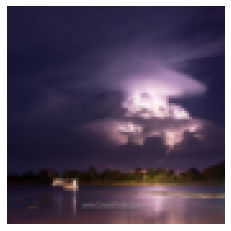

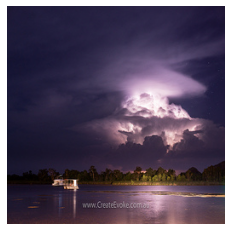

In [7]:
inp,re=load(path+'train/000.png') #casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0);
plt.axis('off');
plt.figure()
plt.imshow(re/255.0);
plt.axis('off');

Resizes the pair of images.

In [8]:
def resize(input_image,real_image,height,width):
  input_image=tf.image.resize(input_image,[height,width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image=tf.image.resize(real_image,[height,width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image,real_image

Crops the pair of images.

In [9]:
def random_crop(input_image,real_image):
  stacked_image=tf.stack([input_image,real_image],axis=0)
  cropped_image=tf.image.random_crop(stacked_image,size=[2,img_height,img_width,3])
  return cropped_image[0],cropped_image[1]

Normalizes the pair of images to [-1, 1].

In [10]:
def normalize(input_image,real_image):
  input_image=(input_image/127.5)-1
  real_image=(real_image/127.5)-1
  return input_image,real_image

Random Jittering (the image is resized to 286 x 286 x 3, randomly cropped to 256 x 256 x 3 and randomly flipped horizontally)

In [11]:
@tf.function()
def random_jitter(input_image,real_image):

  input_image,real_image=resize(input_image,real_image,286,286)
  input_image,real_image=random_crop(input_image,real_image)

  if tf.random.uniform(())>0.5: #random mirroring (flipping horizontally i.e. left to right)
    input_image=tf.image.flip_left_right(input_image)
    real_image=tf.image.flip_left_right(real_image)

  return input_image,real_image

Displays a sample image of the dataset after it has been through random jittering.

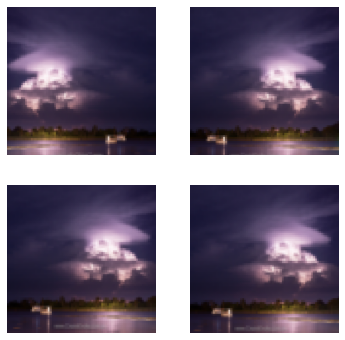

In [12]:
plt.figure(figsize=(6,6))

for i in range(4):
  rj_inp,rj_re=random_jitter(inp,re)
  plt.subplot(2,2,i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
  
plt.show()

In [13]:
def load_image_train(image_file):
  input_image,real_image=load(image_file)
  input_image,real_image=random_jitter(input_image,real_image)
  input_image,real_image=normalize(input_image,real_image)
  return input_image,real_image

In [14]:
def load_image_test(image_file):
  input_image,real_image=load(image_file)
  input_image,real_image=resize(input_image, real_image,img_height,img_width)
  input_image,real_image=normalize(input_image,real_image)
  return input_image,real_image

Input Pipeline

In [15]:
train_dataset=tf.data.Dataset.list_files(path+'train/*.png')
test_dataset=tf.data.Dataset.list_files(path+'test/*.png')
train_dataset=train_dataset.map(load_image_train,num_parallel_calls=tf.data.AUTOTUNE)
test_dataset=test_dataset.map(load_image_test)
train_dataset=train_dataset.shuffle(buffer_size)
train_dataset=train_dataset.batch(batch_size) 
test_dataset=test_dataset.batch(batch_size)
output_channels=3

The Generator (a modified U-Net)

In [16]:
def downsample(filters,size,apply_batchnorm=True): #encoder, Conv -> Batchnorm -> Leaky ReLU

  initializer=tf.random_normal_initializer(0.,0.02)
  result=tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters,size,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())
  return result

In [17]:
down_model=downsample(3,4)
down_result=down_model(tf.expand_dims(inp,0))

In [19]:
def upsample(filters,size,apply_dropout=False): #decoder, Transposed Conv -> Batchnorm -> Dropout -> ReLU

  initializer=tf.random_normal_initializer(0.,0.02)
  result=tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters,size,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())
  return result

In [20]:
up_model=upsample(3,4)
up_result=up_model(down_result)

In [21]:
def Generator():

  inputs=tf.keras.layers.Input(shape=[256,256,3])

  down_stack=[downsample(64,4,apply_batchnorm=False),
              downsample(128,4),
              downsample(256,4),
              downsample(512,4),
              downsample(512,4),
              downsample(512,4),
              downsample(512,4),
              downsample(512,4),]

  up_stack=[upsample(512,4,apply_dropout=True),
            upsample(512,4,apply_dropout=True),
            upsample(512,4,apply_dropout=True),
            upsample(512,4),
            upsample(256,4),
            upsample(128,4),
            upsample(64,4),]

  initializer=tf.random_normal_initializer(0.,0.02)
  last=tf.keras.layers.Conv2DTranspose(output_channels,4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh')
  x=inputs
  skips=[]

  for down in down_stack: #downsampling through the model
    x=down(x)
    skips.append(x)

  skips=reversed(skips[:-1])

  for up,skip in zip(up_stack,skips): #upsampling and establishing the skip connections between the encoder and decoder
    x=up(x)
    x=tf.keras.layers.Concatenate()([x,skip])

  x=last(x)
  return tf.keras.Model(inputs=inputs,outputs=x)

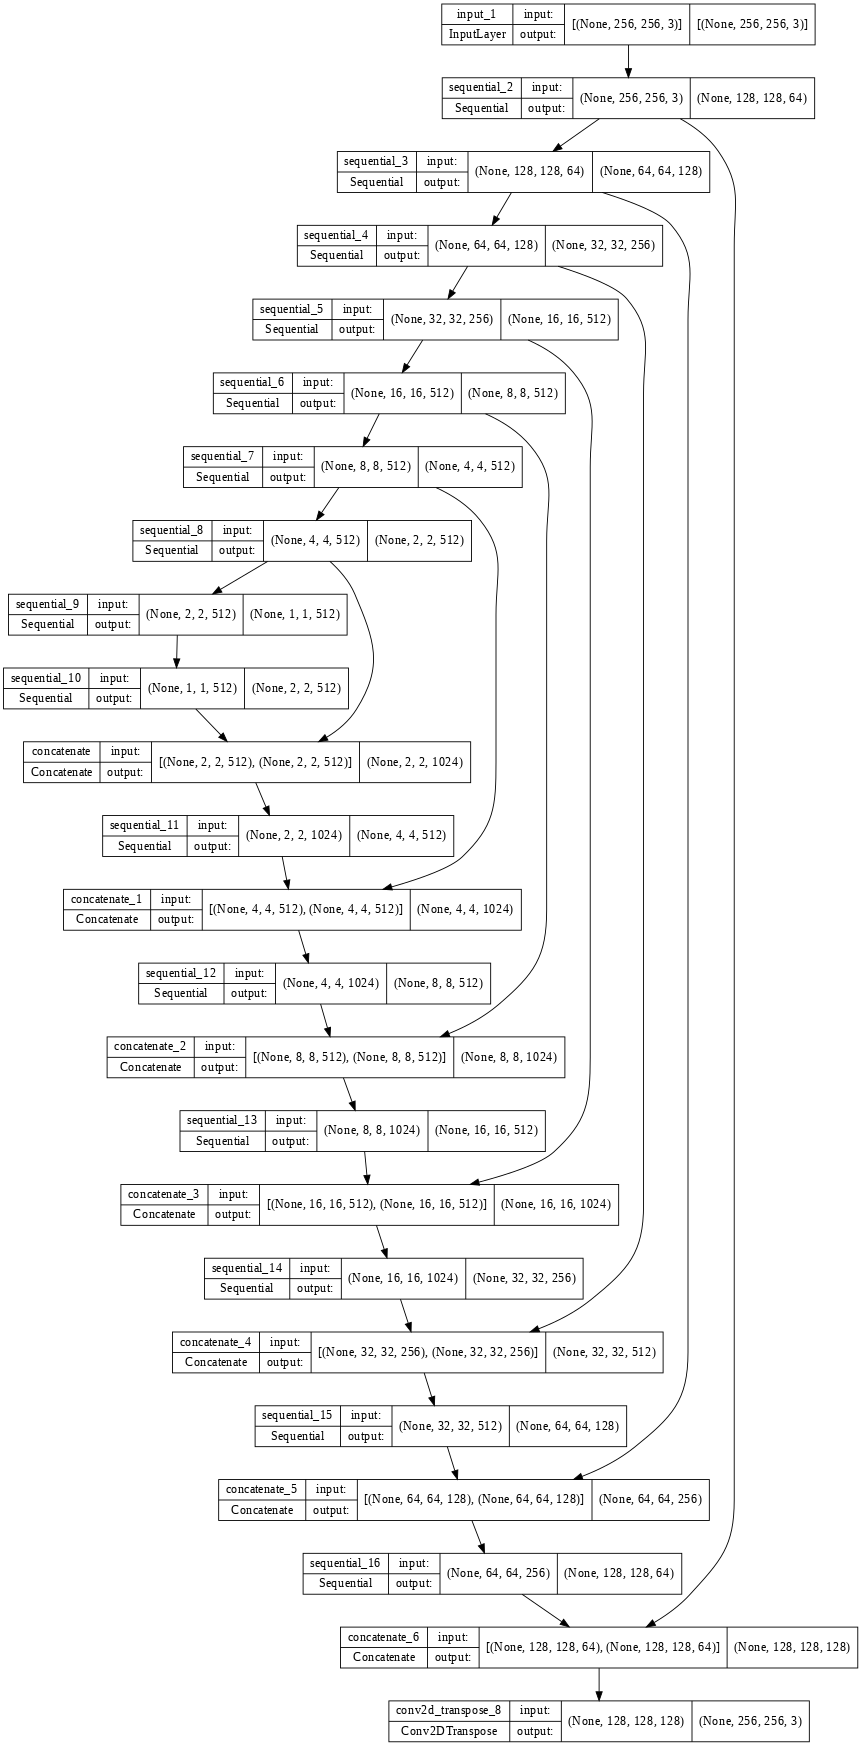

In [22]:
generator=Generator()
tf.keras.utils.plot_model(generator,show_shapes=True,dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


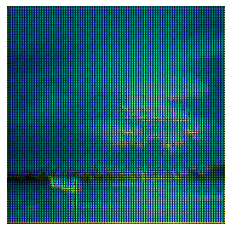

In [23]:
gen_output=generator(inp[tf.newaxis,...],training=False)
plt.imshow(gen_output[0,...]);
plt.axis('off');

Generator Loss (a sigmoid cross entropy loss of the generated images and an array of ones)

In [24]:
Lambda=100

In [25]:
def generator_loss(disc_generated_output,gen_output,target): #allows the generated image to become structurally similar to the target image
  gan_loss=loss_object(tf.ones_like(disc_generated_output),disc_generated_output)
  l1_loss=tf.reduce_mean(tf.abs(target-gen_output)) #mean absolute error between the generated image and target image
  total_gen_loss=gan_loss+(Lambda*l1_loss)
  return total_gen_loss,gan_loss,l1_loss

The Discriminator (a PatchGAN, each 30 x 30 patch of the output classifies a 70 x 70 portion of the input image)

In [26]:
def Discriminator(): #Conv -> BatchNorm -> Leaky ReLU
  initializer=tf.random_normal_initializer(0.,0.02)
  inp=tf.keras.layers.Input(shape=[256,256,3],name='input_image')
  tar=tf.keras.layers.Input(shape=[256,256,3],name='target_image')
  x=tf.keras.layers.concatenate([inp,tar])
  down1=downsample(64,4,False)(x)
  down2=downsample(128,4)(down1)
  down3=downsample(256,4)(down2)
  zero_pad1=tf.keras.layers.ZeroPadding2D()(down3)
  conv=tf.keras.layers.Conv2D(512,4,strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1)
  batchnorm1=tf.keras.layers.BatchNormalization()(conv)
  leaky_relu=tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2=tf.keras.layers.ZeroPadding2D()(leaky_relu)
  last=tf.keras.layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zero_pad2)
  return tf.keras.Model(inputs=[inp,tar],outputs=last)

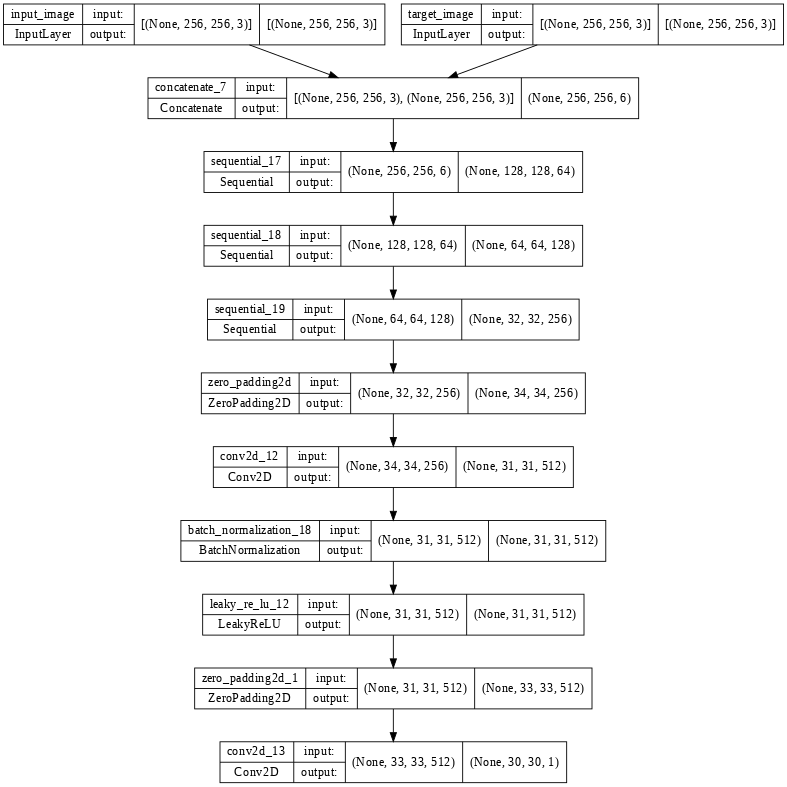

In [27]:
discriminator=Discriminator()
tf.keras.utils.plot_model(discriminator,show_shapes=True,dpi=64)

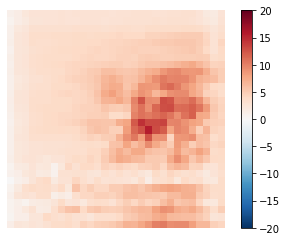

In [28]:
disc_out=discriminator([inp[tf.newaxis,...],gen_output], training=False)
plt.imshow(disc_out[0,...,-1],vmin=-20,vmax=20,cmap='RdBu_r')
plt.colorbar();
plt.axis('off');

Discriminator Loss

In [29]:
loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def discriminator_loss(disc_real_output,disc_generated_output):
  real_loss=loss_object(tf.ones_like(disc_real_output),disc_real_output) #a sigmoid cross entropy loss of the real images and an array of ones (since these are the real images)
  generated_loss=loss_object(tf.zeros_like(disc_generated_output),disc_generated_output) #a sigmoid cross entropy of the generated images and an array of zeros (since these are fake images)
  total_disc_loss=real_loss+generated_loss
  return total_disc_loss

Defines the optimizers.

In [32]:
generator_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

Plots some images during training.

In [33]:
def generate_images(model,test_input,tar):
  prediction=model(test_input,training=True)
  plt.figure(figsize=(15,15))
  display_list=[test_input[0],tar[0],prediction[0]]
  title=['Input Image','Ground Truth','Predicted Image']

  for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(title[i])
    plt.imshow(display_list[i]*0.5+0.5)
    plt.axis('off')
    
  plt.show()

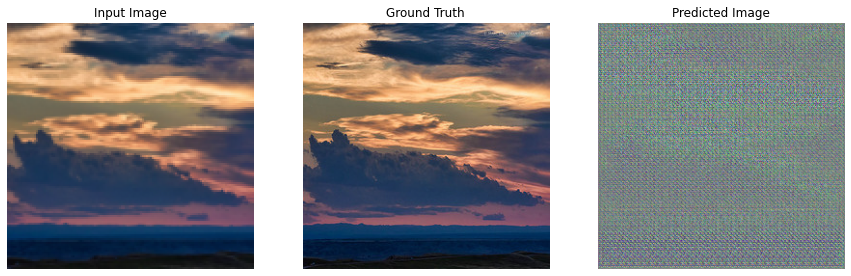

In [34]:
for example_input,example_target in test_dataset.take(1):
  generate_images(generator,example_input,example_target)

Training

In [36]:
epochs=11

In [37]:
@tf.function
def train_step(input_image,target,epoch):
  
  with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    gen_output=generator(input_image,training=True)
    disc_real_output=discriminator([input_image,target],training=True)
    disc_generated_output=discriminator([input_image,gen_output],training=True)
    gen_total_loss,gen_gan_loss,gen_l1_loss=generator_loss(disc_generated_output,gen_output,target)
    disc_loss=discriminator_loss(disc_real_output,disc_generated_output)

  generator_gradients=gen_tape.gradient(gen_total_loss,generator.trainable_variables)
  discriminator_gradients=disc_tape.gradient(disc_loss,discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

In [38]:
def fit(train_ds,epochs,test_ds):

  for epoch in range(epochs): #on each epoch the display is cleared and generate_images is run to display progress
    display.clear_output(wait=True)

    for example_input,example_target in test_ds.take(1):
      generate_images(generator,example_input,example_target)
    
    print("Epoch: ",epoch)

    for n,(input_image, target) in train_ds.enumerate():
      train_step(input_image,target,epoch)

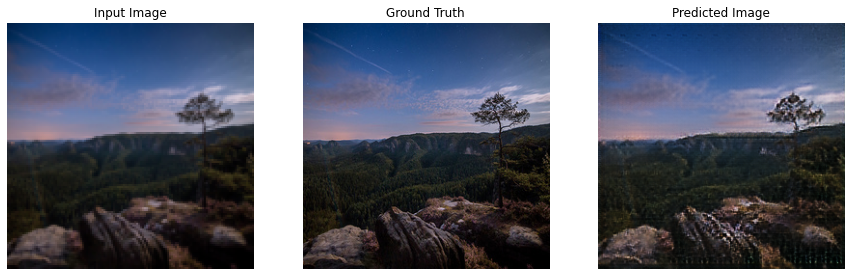

Epoch:  10


In [40]:
fit(train_dataset,epochs,test_dataset)

Tests the model using the test dataset.

In [41]:
for inp,tar in test_dataset.take(5):
  generate_images(generator,inp,tar)

Output hidden; open in https://colab.research.google.com to view.

Load Model

In [ ]:
generator.save('model.h5')
new_model=tf.keras.models.load_model('/content/model.h5',compile=False)

In [55]:
uploaded=files.upload()

Saving IMG_5281.png to IMG_5281 (1).png


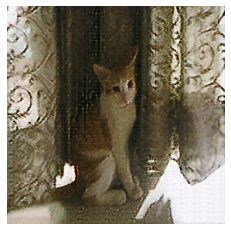

In [53]:
image=tf.io.read_file('IMG_5281.png')
image=tf.image.decode_png(image,channels=3)
image=tf.image.resize(image,[256,256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
image=tf.cast(image,tf.float32)
image=(image/127.5)-1
prediction=new_model(tf.expand_dims(image,0),training=True)
plt.imshow(prediction[0]*0.5+0.5);
plt.axis('off');